In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.colors as mcolors


In [3]:
DATASET_NAME = "dataset"
MODEL_NAME = 'VanillaCNN'
DATASET_VAR = 'base_final'
MODEL_PATH = f'./models/{MODEL_NAME}'

In [4]:
results_orig = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/results/results_borig.npz')
results_baugm = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/results/results_baugm_final.npz')
results_augm = np.load('/home/giacomoschiavo/finetuning-BirdNET/models/VanillaCNN/augm_final/results.npz')

y_true_orig = results_orig['y_true']
y_pred_orig = results_orig['y_pred']
y_pred_proba_orig = results_orig['y_pred_proba']
y_true_baugm = results_baugm['y_true']
y_pred_baugm = results_baugm['y_pred']
y_pred_proba_baugm = results_baugm['y_pred_proba']
y_true_augm = results_augm['y_true']
y_pred_augm = results_augm['y_pred']
y_pred_proba_augm = results_augm['y_pred_proba']
class_names = results_augm['class_names']

In [5]:
models_results = {
    'Original': {
        'y_true': results_orig['y_true'],
        'y_pred': results_orig['y_pred'], 
        'y_pred_proba': results_orig['y_pred_proba']
    },
    'BirdNET - FineTuned + data augm': {
        'y_true': results_baugm['y_true'],
        'y_pred': results_baugm['y_pred'],
        'y_pred_proba': results_baugm['y_pred_proba']
    },
    'Vanilla CNN - FineTuned + data augm': {
        'y_true': results_augm['y_true'],
        'y_pred': results_augm['y_pred'],
        'y_pred_proba': results_augm['y_pred_proba']
    }
}


In [6]:
def plot_roc_curves_multiple_models(models_results, class_names=None, top_n=10):
    """
    Disegna le curve ROC per più modelli in subplot (3 per riga).
    
    Parameters:
    -----------
    models_results : dict
        Dizionario con i risultati di ogni modello nel formato:
        {
            'model_name': {
                'y_true': array,
                'y_pred': array, 
                'y_pred_proba': array
            },
            ...
        }
    class_names : list, optional
        Lista di nomi delle classi (se None, usa indici numerici)
    top_n : int, optional
        Numero di classi migliori da visualizzare per AUC (default: 10)
    """
    
    n_models = len(models_results)
    model_names = list(models_results.keys())
    
    # Calcolo il numero di righe necessarie (3 modelli per riga)
    n_rows = (n_models + 2) // 3
    
    # Creo la figura con subplot
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6*n_rows))
    fig.suptitle('Curve ROC - Confronto Modelli', fontsize=16, y=0.98)
    
    # Se ho solo una riga, assicurati che axes sia sempre un array 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_models == 1:
        axes = np.array([[axes]])
    
    # Colori per le classi
    bright_colors = [
        '#FF0000', '#00FA9A', '#0000FF', '#FF00FF', '#00FFFF',
        '#FFFF00', '#FF8000', '#8000FF', '#0080FF', '#8B4513'
    ]
    
    # Processo ogni modello
    for idx, (model_name, results) in enumerate(models_results.items()):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        y_true = results['y_true']
        y_pred_proba = results['y_pred_proba']
        n_classes = y_true.shape[1]
        
        # Se non sono specificati nomi delle classi, uso indici numerici
        if class_names is None:
            current_class_names = [f"classe {i}" for i in range(n_classes)]
        else:
            current_class_names = class_names
        
        # Calcolo l'AUC per ogni classe e seleziono le top_n migliori
        auc_scores = []
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            auc_scores.append((i, roc_auc))
        
        # Ordino per AUC decrescente e prendo le top_n migliori
        auc_scores.sort(key=lambda x: x[1], reverse=True)
        selected_classes = [idx_class for idx_class, _ in auc_scores[:top_n]]
        
        # Colori per le classi
        if n_classes > len(bright_colors):
            additional_colors = list(mcolors.TABLEAU_COLORS.values())
            all_colors = bright_colors + additional_colors
        else:
            all_colors = bright_colors
            
        color_dict = {i: all_colors[i % len(all_colors)] for i in range(n_classes)}
        
        # Plotto le curve ROC per le classi selezionate
        for i in selected_classes:
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, color=color_dict[i],
                   label=f'{current_class_names[i].split("_")[0]} ({roc_auc:.3f})')
        
        # Linea diagonale di riferimento
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.7)
        
        # Configurazione del subplot
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Tasso di falsi positivi (1 - Specificità)')
        ax.set_ylabel('Tasso di veri positivi (Sensibilità)')
        ax.set_title(f'{model_name}')
        ax.grid(True, alpha=0.3)
        
        # Legenda fuori dal grafico
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Nascondo i subplot vuoti se il numero di modelli non è multiplo di 3
    for idx in range(n_models, n_rows * 3):
        row = idx // 3
        col = idx % 3
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Spazio per il titolo principale
    plt.show()


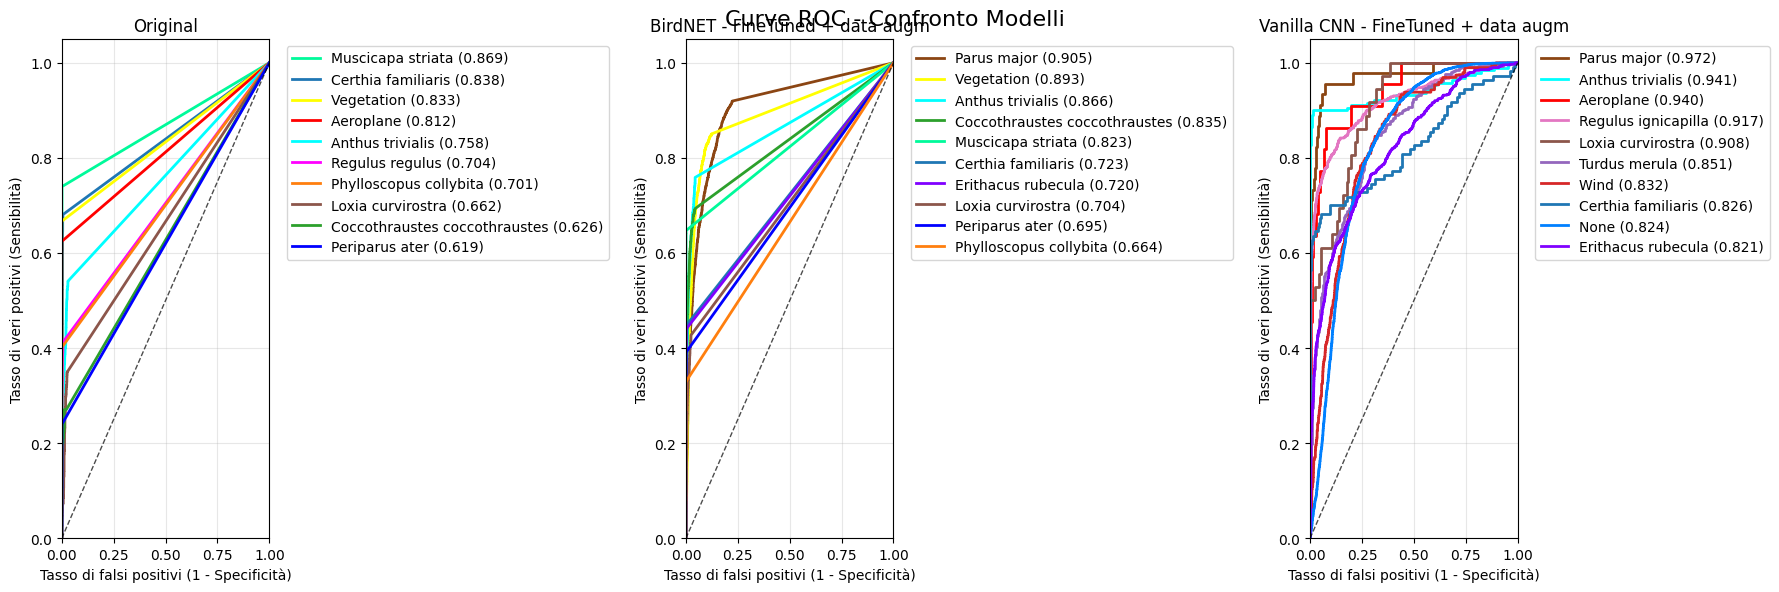

In [7]:
plot_roc_curves_multiple_models(models_results, class_names=class_names, top_n=10)

# Classification report

In [14]:
from sklearn.metrics import classification_report
import pandas as pd
from io import StringIO

clf_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
clf_report_df = pd.read_json(StringIO(json.dumps(clf_report)), orient='index')
clf_report_df

,precision,recall,f1-score,support
Aeroplane,0.000000,0.000000,0.000000,22
Muscicapa striata_Spotted Flycatcher,0.000000,0.000000,0.000000,173
Periparus ater_Coal Tit,0.854167,0.377880,0.523962,217
Cuculus canorus_Common Cuckoo,0.000000,0.000000,0.000000,3
Regulus regulus_Goldcrest,0.673469,0.242647,0.356757,136
Anthus trivialis_Tree Pipit,0.968944,0.816754,0.886364,191
Vegetation,0.818182,0.166667,0.276923,54
Troglodytes troglodytes_Eurasian Wren,0.335025,0.312796,0.323529,211
Erithacus rubecula_European Robin,0.693878,0.197101,0.306998,690
None,0.790018,0.767243,0.778464,4683


# ROC AUC Curve

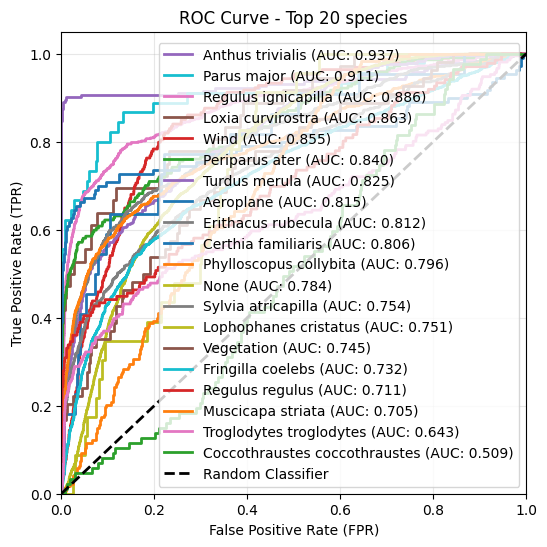

In [15]:
def plot_roc_curves(y_true, y_pred_proba, class_names=None, selected_classes=None, top_n=10):
    """
    Disegna le curve ROC per ogni classe in un problema di classificazione multi-label.
    
    Parameters:
    -----------
    y_true : array, shape = (n_samples, n_classes)
        Etichette vere in formato one-hot encoding (0 o 1)
    y_pred_proba : array, shape = (n_samples, n_classes)
        Probabilità predette per ogni classe
    class_names : list, optional
        Lista di nomi delle classi (se None, usa indici numerici)
    selected_classes : list, optional
        Lista di indici delle classi da visualizzare (se None, mostra le top_n migliori per AUC)
    top_n : int, optional
        Numero di classi migliori da visualizzare (default: 10)
    """
    n_classes = y_true.shape[1]
    
    # Se non sono specificati nomi delle classi, uso indici numerici
    if class_names is None:
        class_names = [f"classe {i}" for i in range(n_classes)]
    
    # Se non sono specificate classi selezionate, calcolo le top_n migliori per AUC
    if selected_classes is None:
        # Calcolo l'AUC per ogni classe
        auc_scores = []
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            auc_scores.append((i, roc_auc))
        
        # Ordino per AUC decrescente e prendo le top_n migliori
        auc_scores.sort(key=lambda x: x[1], reverse=True)
        selected_classes = [idx for idx, _ in auc_scores[:top_n]]
    
    # Genero un dizionario di colori fissi per ogni classe
    # Utilizzo 20 colori iniziali e li ripeto se necessario
    additional_colors = list(mcolors.TABLEAU_COLORS.values())
        
    color_dict = {i: additional_colors[i % len(additional_colors)] for i in range(n_classes)}
    
    # Preparo il grafico
    plt.figure(figsize=(6, 6))
    
    # Calcolo e disegno le curve ROC solo per le classi selezionate
    for i in selected_classes:
        if i < n_classes:  # Verifico che l'indice sia valido
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, color=color_dict[i],
                     label=f'{class_names[i].split("_")[0]} (AUC: {roc_auc:.3f})')
    
    # Aggiungo la linea diagonale di riferimento (classificatore casuale)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - Top {len(selected_classes)} species')
    plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0))
    plt.grid(True, alpha=0.3)
    plt.show()


plot_roc_curves(y_true, y_pred_proba, class_names=class_names, top_n=20)



# Confusion Matrix

In [15]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_true, y_pred)

conf_matrices = []
for idx, label in enumerate(class_names):
    tn, fp, fn, tp = mcm[idx].ravel()
    conf_matrices.append({
        'Class': label,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

conf_df = pd.DataFrame(conf_matrices)
conf_df

,Class,TP,FP,FN,TN
0,Aeroplane,0,0,22,8953
1,Muscicapa striata_Spotted Flycatcher,0,3,173,8799
2,Periparus ater_Coal Tit,82,14,135,8744
3,Cuculus canorus_Common Cuckoo,0,0,3,8972
4,Regulus regulus_Goldcrest,33,16,103,8823
5,Anthus trivialis_Tree Pipit,156,5,35,8779
6,Vegetation,9,2,45,8919
7,Troglodytes troglodytes_Eurasian Wren,66,131,145,8633
8,Erithacus rubecula_European Robin,136,60,554,8225
9,None,3593,955,1090,3337
